In [2]:
import pennylane as qml

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def xor(input):
    qml.BasisState(input, wires=[0,1])
    qml.CNOT(wires=[0,1])
    return qml.probs(wires=1)

In [3]:
import torch
X = torch.tensor([[0,0], [0,1], [1,0], [1,1]], dtype=torch.float32)
Y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

In [4]:
[xor(xi) for xi in X] # pr [1,0] = stan [0] , pr [0,1] = stan [1]

[tensor([1., 0.], dtype=torch.float64),
 tensor([0., 1.], dtype=torch.float64),
 tensor([0., 1.], dtype=torch.float64),
 tensor([1., 0.], dtype=torch.float64)]

# Wprowadzenie do pennylane 

[Introduction to pennylane](https://sebkaz-teaching.github.io/qml2024/labs/cw2.html)

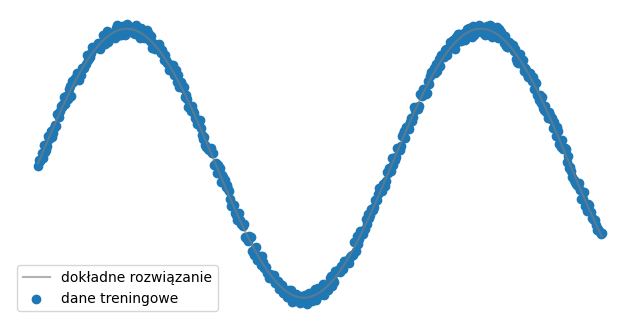

In [5]:
from utils import *
import torch

torch.manual_seed(123)

X_cont = torch.linspace(0,10,500).view(-1,1)
y_cont = torch.sin(X_cont)
y_cont_noise = y_cont + 0.1*(torch.rand(500).view(-1,1)-0.5)

# wyktres danych
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(X_cont, y_cont.view(-1,1), color="tab:grey", alpha=0.6, label="dokładne rozwiązanie")
plt.scatter(X_cont, y_cont_noise, label="dane treningowe")
plt.axis("off")
plt.legend()
plt.show()

In [6]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


# PyTorch Layer
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [7]:
w = [[0.1,0.2],[0.2,0.4],[0.1,0.2]]
inp = [1,0]

(<Figure size 1000x300 with 1 Axes>, <Axes: >)

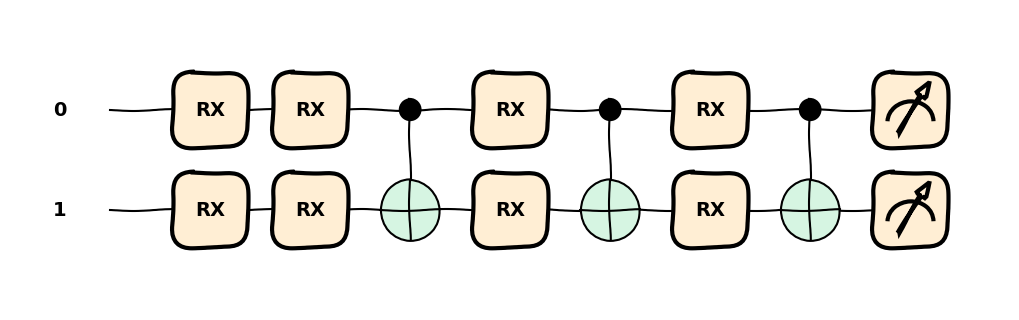

In [8]:
qml.drawer.use_style("sketch")
qml.draw_mpl(qnode, level="device")(inp, w)

In [9]:
class QN(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, n_input: int, n_output: int, quanutm_layer):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(n_input, n_qubits),
            quanutm_layer, # nasza warstwa kwantowa w środku 
            torch.nn.Linear(n_qubits, n_output)
        )
        

    def forward(self, x):
        return  self.layers(x)

In [10]:
reg_qmodel = QN(1, 1, qlayer)
print(reg_qmodel)

QN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): <Quantum Torch Layer: func=qnode>
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)


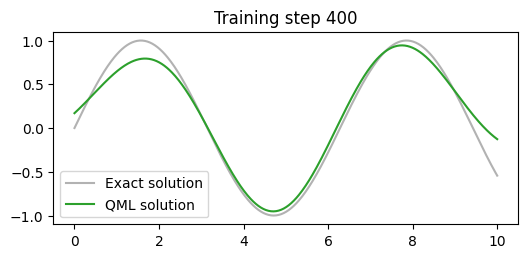

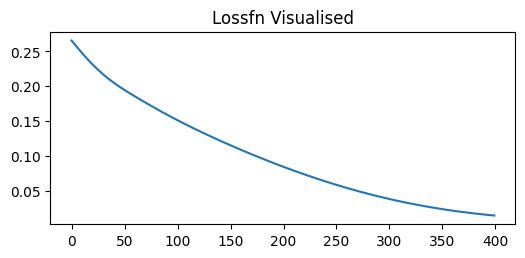

In [11]:
learning_rate=1e-3
optimiser = torch.optim.Adam(reg_qmodel.parameters(), lr=learning_rate)

trainqnn(X_cont, y_cont_noise, reg_qmodel, optimiser, 400, mse, callback)

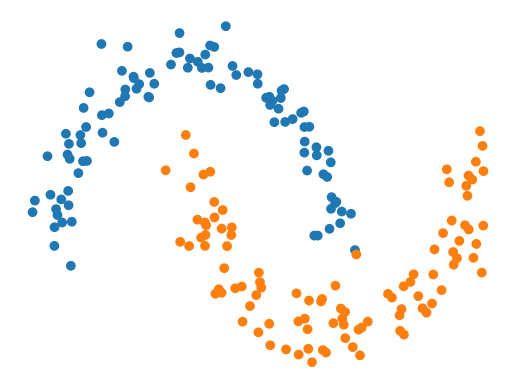

In [12]:
import torch
import pennylane.numpy as np
from sklearn.datasets import make_moons

torch.manual_seed(123)


X, y = make_moons(n_samples=200, noise=0.1)

# create torch

X = torch.from_numpy(X).to(torch.float32)

y_ = torch.from_numpy(y).view(-1,1)


c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # kolorowanie
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()


y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1).to(torch.float32)

# X = X.clone().detach().requires_grad_(True)

In [13]:
class QN2(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, quanutm_layer):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
            quanutm_layer,
            torch.nn.Linear(2, 2),
            torch.nn.Softmax(dim=1)
        )
        

    def forward(self, x):
        return  self.layers(x)

![](./img/model1.png)

In [14]:
qclassifier = QN2(qlayer)
print(qclassifier)

opt = torch.optim.SGD(qclassifier.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

QN2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): <Quantum Torch Layer: func=qnode>
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)


In [15]:
batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(qclassifier(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = qclassifier(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.4078
Average loss over epoch 2: 0.2464
Average loss over epoch 3: 0.1948
Average loss over epoch 4: 0.1721
Average loss over epoch 5: 0.1580
Average loss over epoch 6: 0.1543
Accuracy: 88.5%


In [16]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

![](./img/model2.png)

In [17]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.4595
Average loss over epoch 2: 0.2863
Average loss over epoch 3: 0.1957
Average loss over epoch 4: 0.1700
Average loss over epoch 5: 0.1568
Average loss over epoch 6: 0.1493
Accuracy: 87.0%
